In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay, ModelBasedPrioritizedExperienceReplay
from experiment import Experiment
from dmlac import DMLAC
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy

In [4]:
settings = dict(
    environment = 'Pendulum-v0',
    timesteps = 2500,
    max_replay_buffer_size = 100000,
    batch_size = 256,
    learning_start = 256,
    forward_steps = 1,
    discount_factor = 0.9,
    trace_decay = 0.5,
    
    actor_learning_rate=0.0001,
    model_learning_rate=0.001,
    reward_learning_rate=0.001,
    value_learning_rate=0.001,
    
    actor_l2=None,
    model_l2=None,
    reward_l2=None,
    value_l2=None,
    
    actor_target_approach_rate=0.99,
    value_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.elu,
    actor_bounded_output = True,
    value_net_layers =  [256, 128],
    value_net_activation_fn = tf.nn.elu,
    model_net_embedding = 128,
    model_net_layers = [128],
    model_net_activation_fn = tf.nn.elu,
    reward_net_embedding = 128,
    reward_net_layers =  [128],
    reward_net_activation_fn = tf.nn.elu,
    
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 1,
    
    render_environment = True,
    render_frequency = 10,
    render_start=2000,
)

settings["experiment_path"] = "experiments/experiment_dmlac_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["model_tf_optimizer"] = tf.train.AdamOptimizer(settings["model_learning_rate"])
settings["reward_tf_optimizer"] = tf.train.AdamOptimizer(settings["reward_learning_rate"])
settings["value_tf_optimizer"] = tf.train.AdamOptimizer(settings["value_learning_rate"])

print(settings["experiment_path"])

experiments/experiment_dmlac_Pendulum-v0_1495387262


In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    if settings["environment"] == "MountainCarContinuous-v0":
        return reward * 0.01
    else:
        return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-21 19:21:02,418] Making new env: Pendulum-v0


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)

3
1
[ 1.  1.  8.]
[-1. -1. -8.]
[ 2.]
[-2.]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
summary_writer = tf.summary.FileWriter(settings["experiment_path"] + "/logdir")

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, False)
model_network = nn.fully_connected_with_input_embedding(
    "Model", session, [state_dim, action_dim], settings["model_net_embedding"], settings["model_net_layers"], state_dim,
     settings["model_net_activation_fn"], None, False)
reward_network = nn.fully_connected_with_input_embedding(
    "Reward", session, [state_dim, action_dim], settings["reward_net_embedding"], settings["reward_net_layers"], 1,
     settings["reward_net_activation_fn"], None, False)
value_network = nn.fully_connected("Value", session, [state_dim], settings["value_net_layers"], 1,
                               settings["value_net_activation_fn"], None, False)
print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> hidden_0_256
['hidden_0_256'] --> hidden_1_128
['hidden_1_128'] --> output
['output'] --> bounding



In [10]:
agent = DMLAC(actor_network, model_network, reward_network, value_network,
                 forward_steps=settings["forward_steps"],
                 discount_factor=settings["discount_factor"],
                 trace_decay=settings["trace_decay"],
                 actor_tf_optimizer=settings["actor_tf_optimizer"],
                 model_tf_optimizer=settings["model_tf_optimizer"],
                 reward_tf_optimizer=settings["reward_tf_optimizer"],
                 value_tf_optimizer=settings["value_tf_optimizer"],
                 actor_l2=settings["actor_l2"],
                 model_l2=settings["model_l2"],
                 reward_l2=settings["reward_l2"],
                 value_l2=settings["value_l2"],
                 actor_target_approach_rate=settings["actor_target_approach_rate"],
                 value_target_approach_rate=settings["value_target_approach_rate"],
                 summary_writer=summary_writer
                )

In [11]:
saver = tf.train.Saver()
summary_writer.add_graph(session.graph)

In [12]:
experience_replay = ModelBasedPrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], episodic=False)

In [13]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [14]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

e_t = -1
for t in xrange(settings["timesteps"]):
    e_t += 1
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 4
    if t < settings["learning_start"]:
        exploration = 1
    
    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done)
    td_error = math.fabs(experience_replay.get_last_td_error())
    model_error = experience_replay.get_last_model_error()
    reward_error = experience_replay.get_last_reward_error()

    exp.record(t, state, action, reward, next_state, done, td_error, model_error, reward_error)
    
    state = next_state
    
    if done:
        exp.print_last_episode_info()
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = -1
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}, model error: {:.4f}, reward error: {:.4f}' \
        .format(t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error, model_error, reward_error))
    progress_bar.update()
    
        
progress_bar.close()

[2499] reward: -0.03, reward 100-step MA: -0.03, Exploration: 0.00, action: [ 0.90205479], td-error: 0.0000, model error: 0.0003, reward error: 0.0000: 100%|██████████| 2500/2500 [07:06<00:00,  5.24it/s]    1/2500 [00:00<18:03,  2.31it/s]


In [15]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_dmlac_Pendulum-v0_1495387262


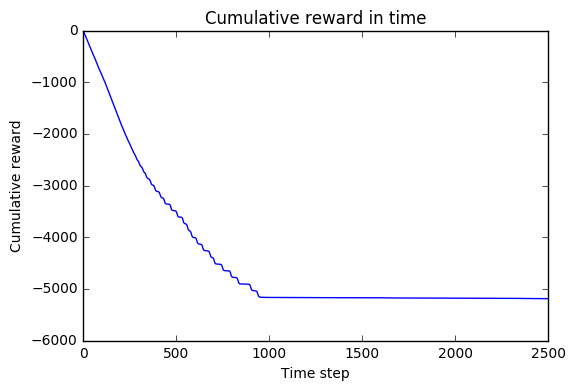

In [16]:
exp.plot_cumulative_reward()

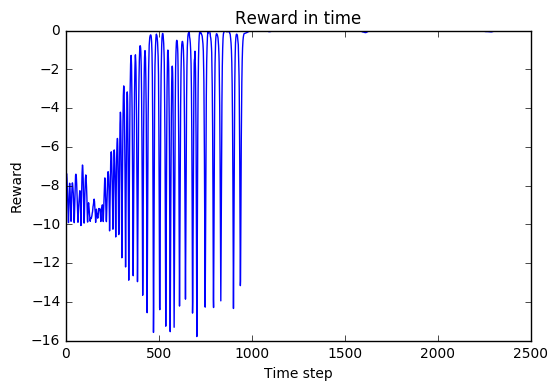

In [17]:
exp.plot_reward()

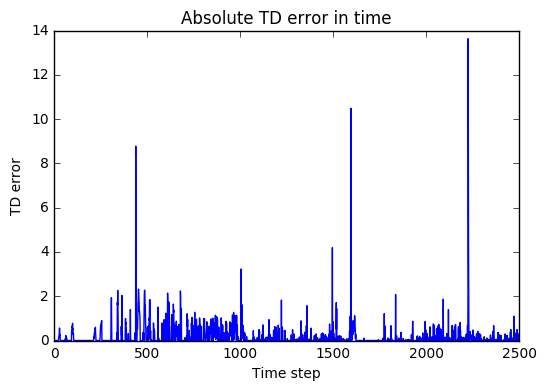

In [18]:
exp.plot_td_error()

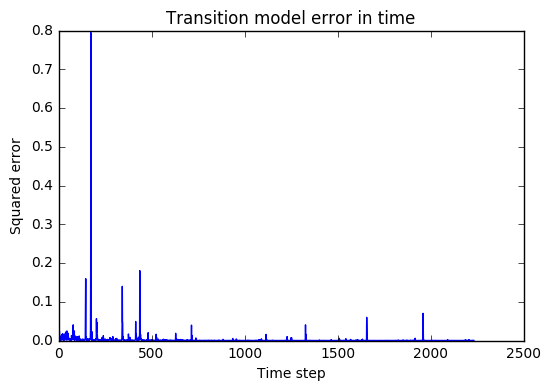

In [19]:
exp.plot_model_error(skip_steps=settings["learning_start"]+10)

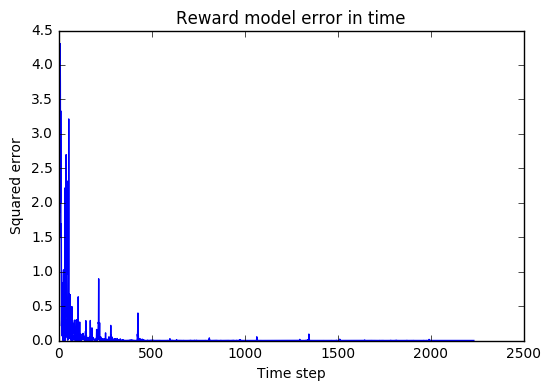

In [20]:
exp.plot_reward_error(skip_steps=settings["learning_start"]+10)

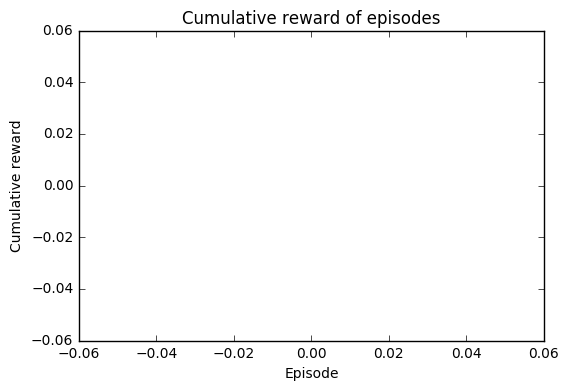

In [21]:
exp.plot_episode_reward()

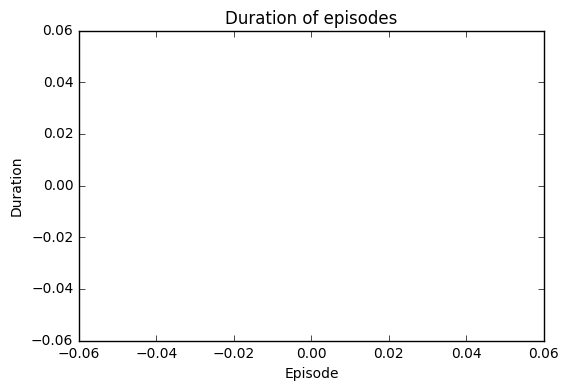

In [22]:
exp.plot_episode_duration()


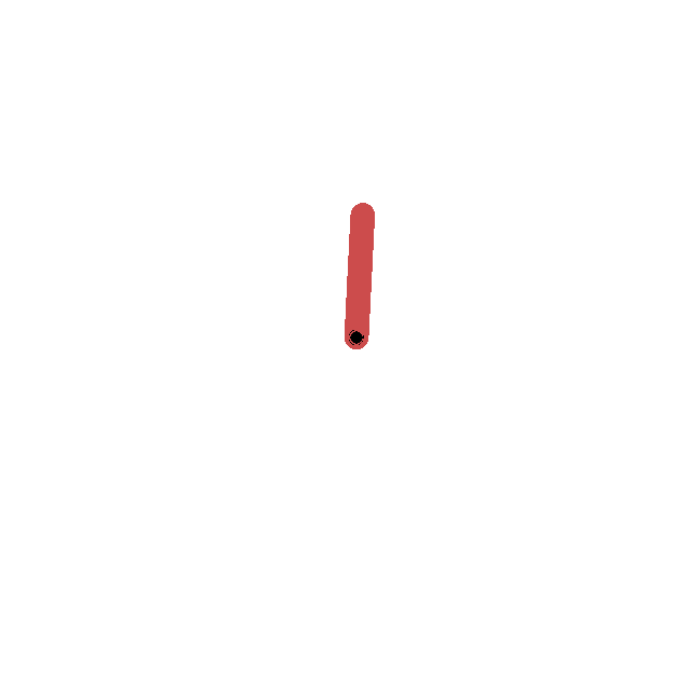
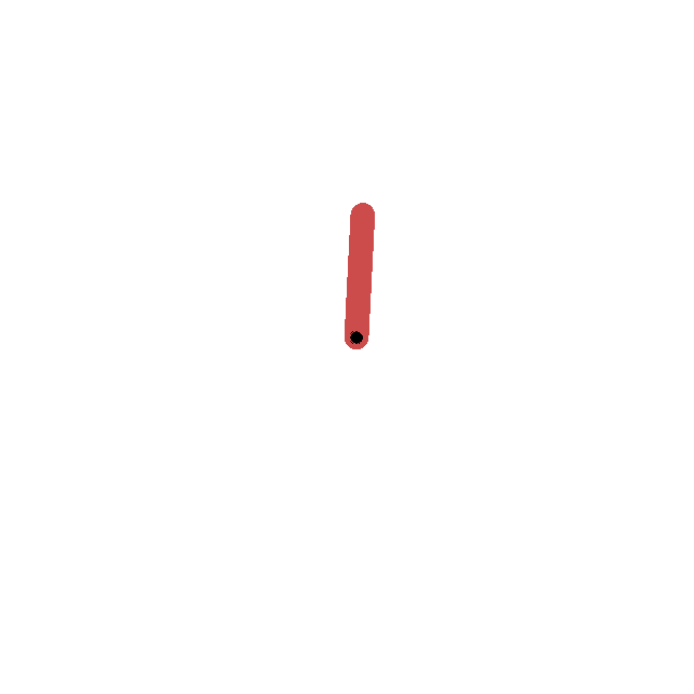
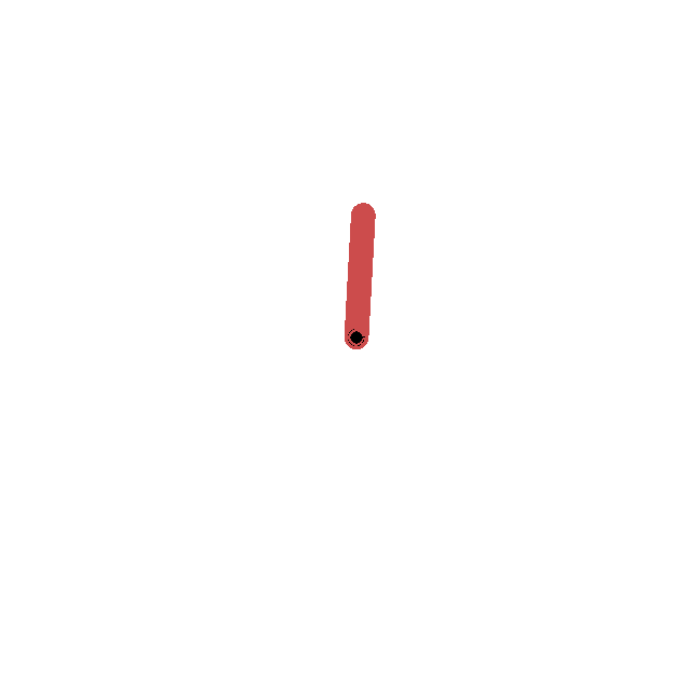
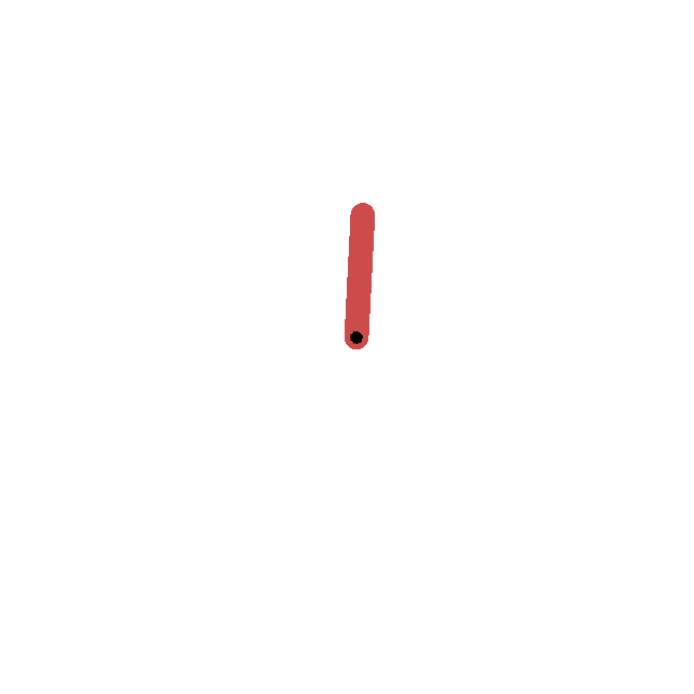
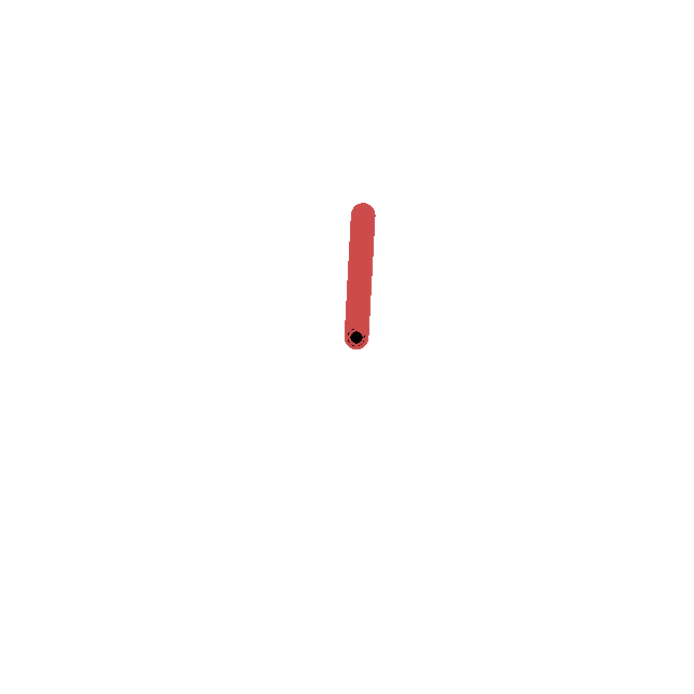
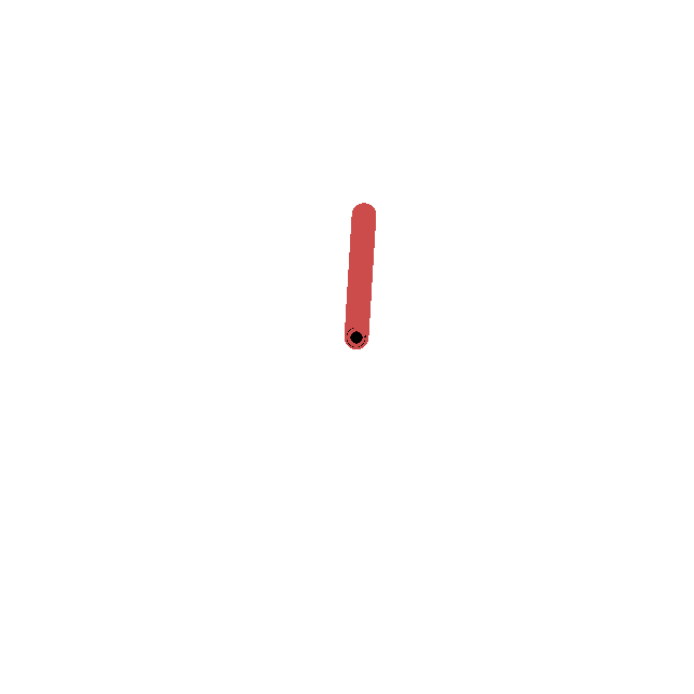
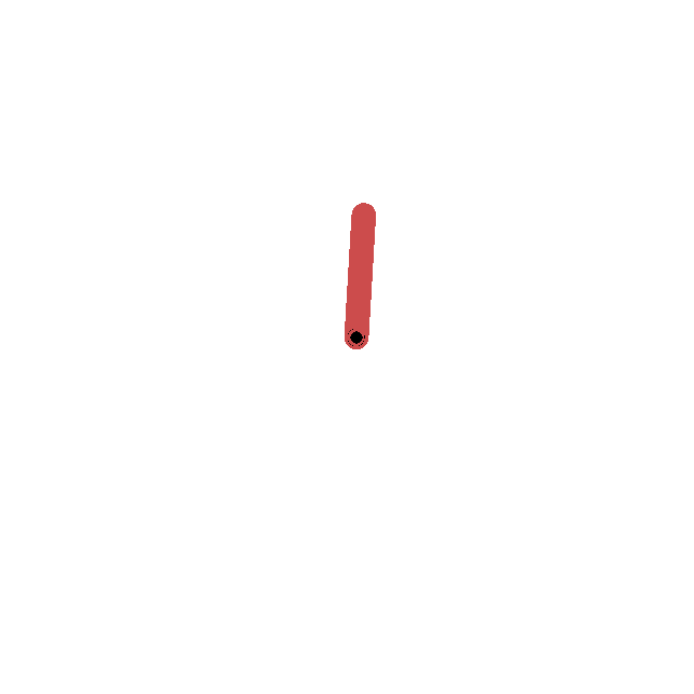
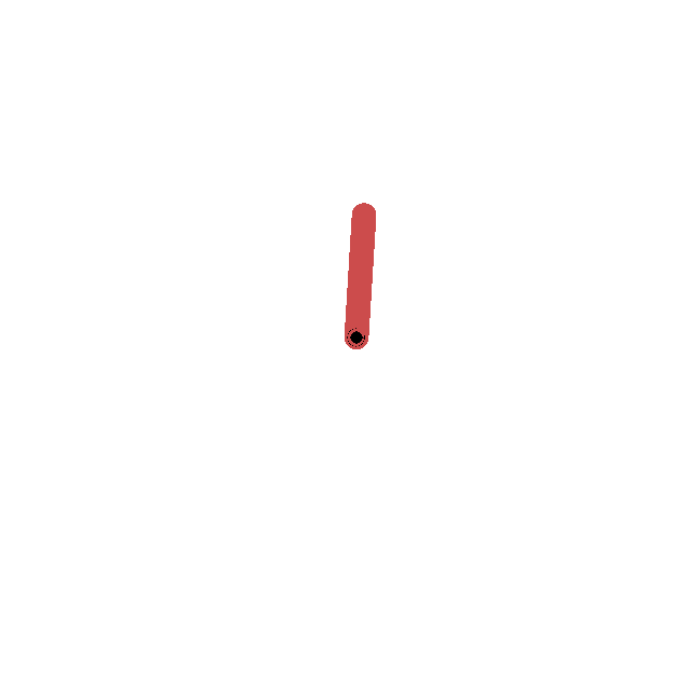
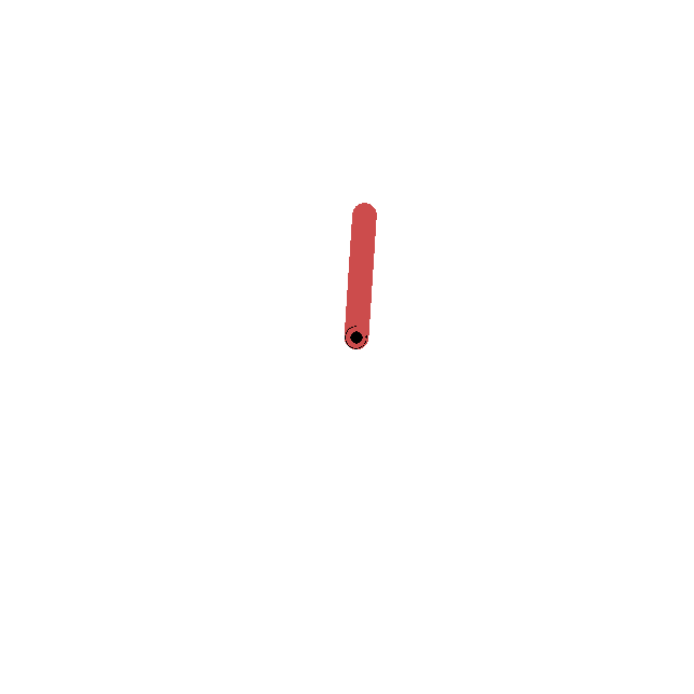
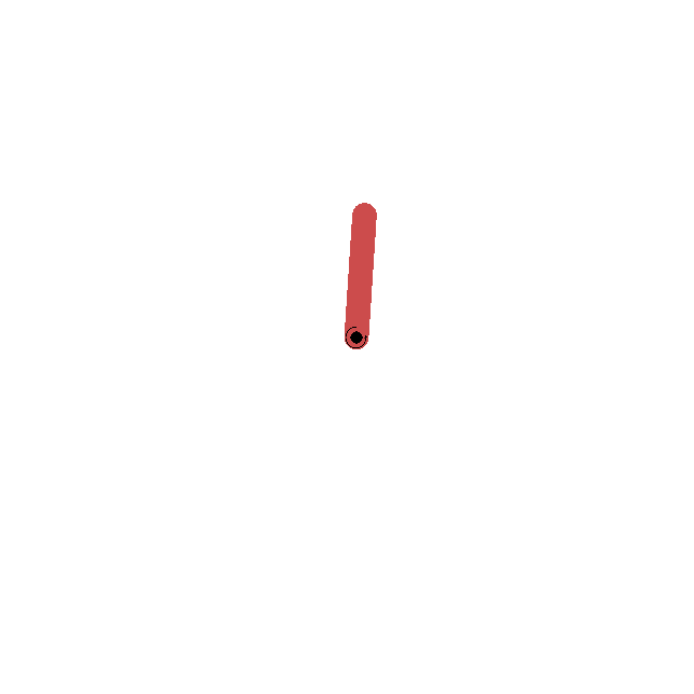
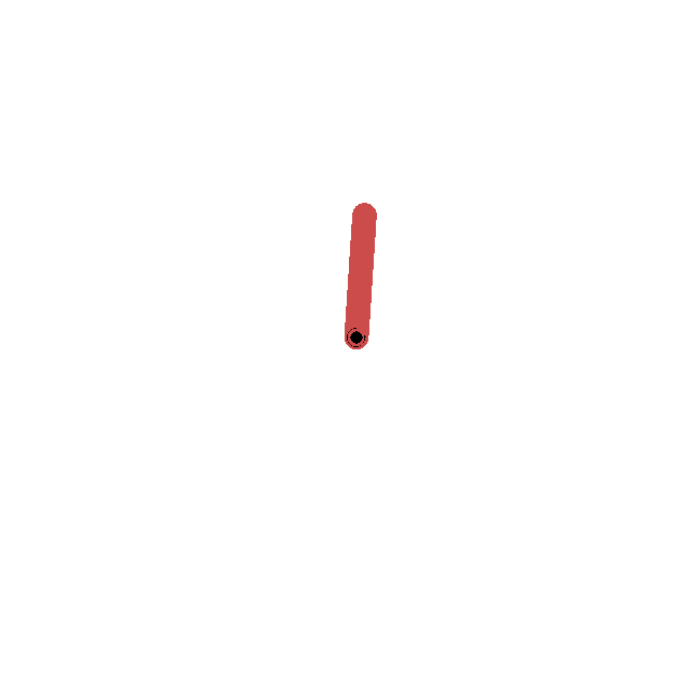
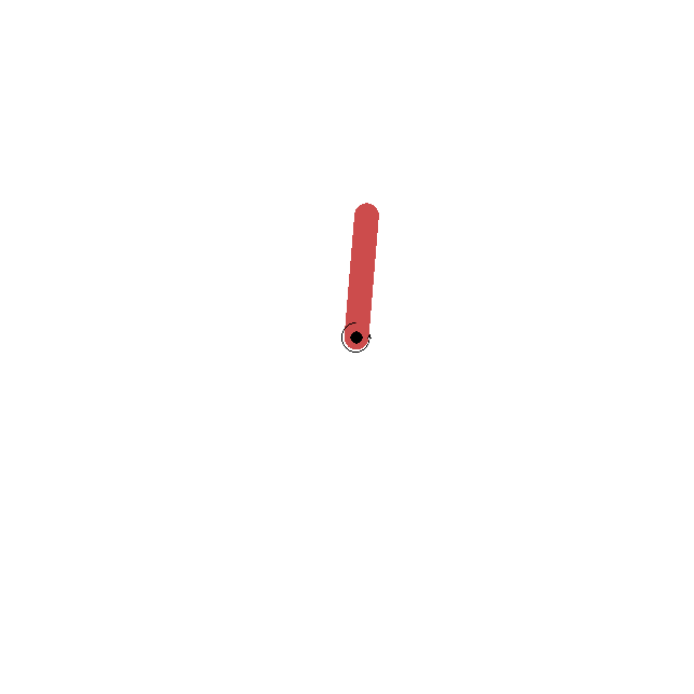
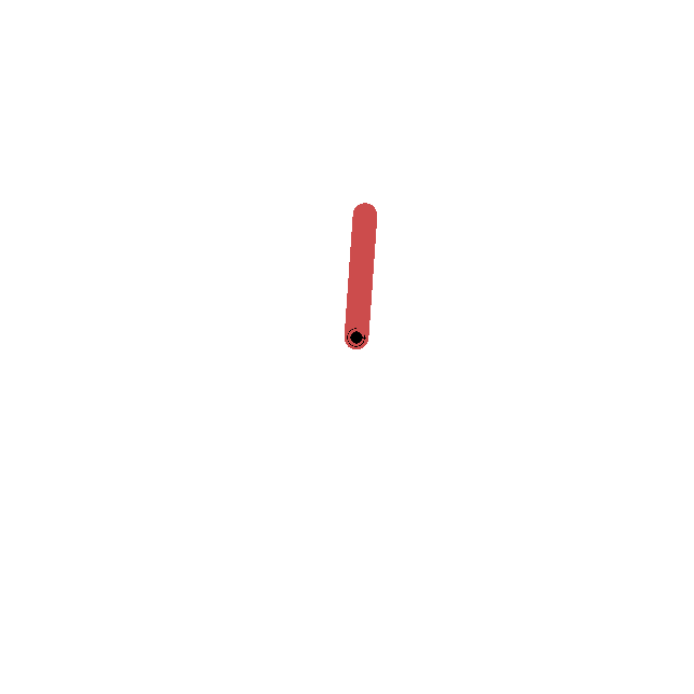
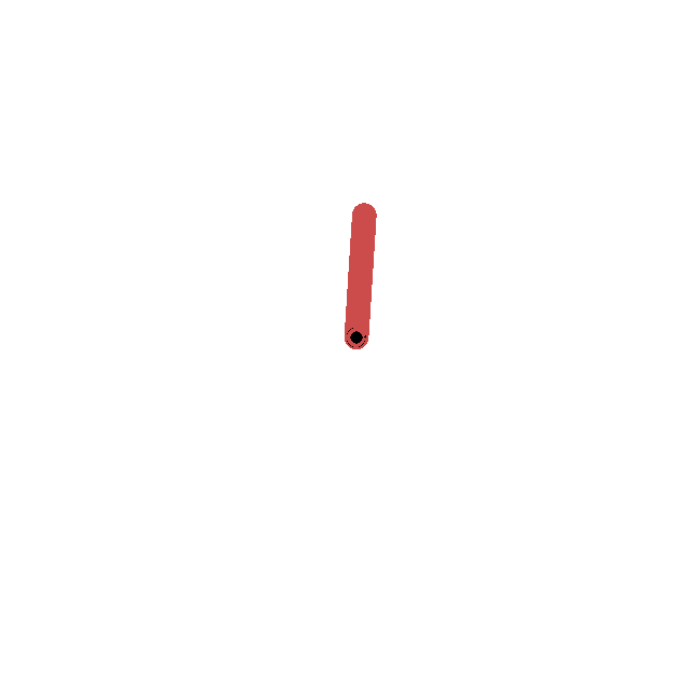
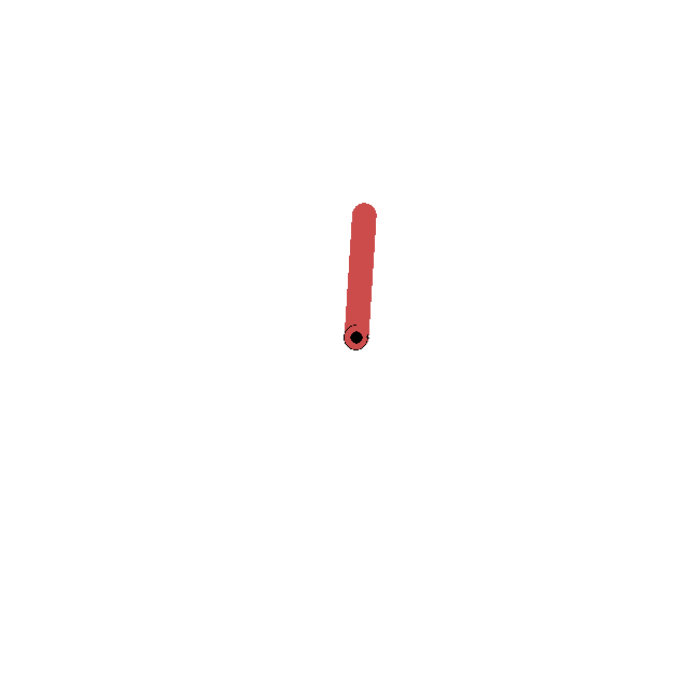
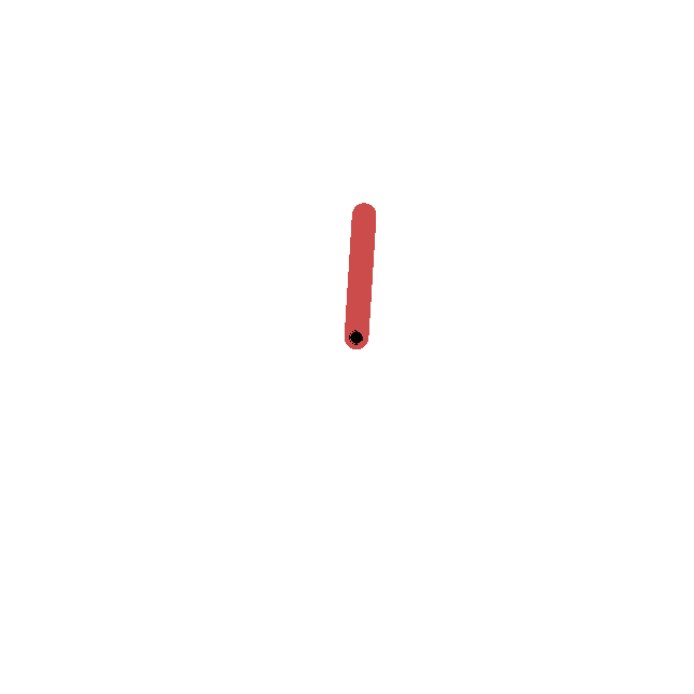
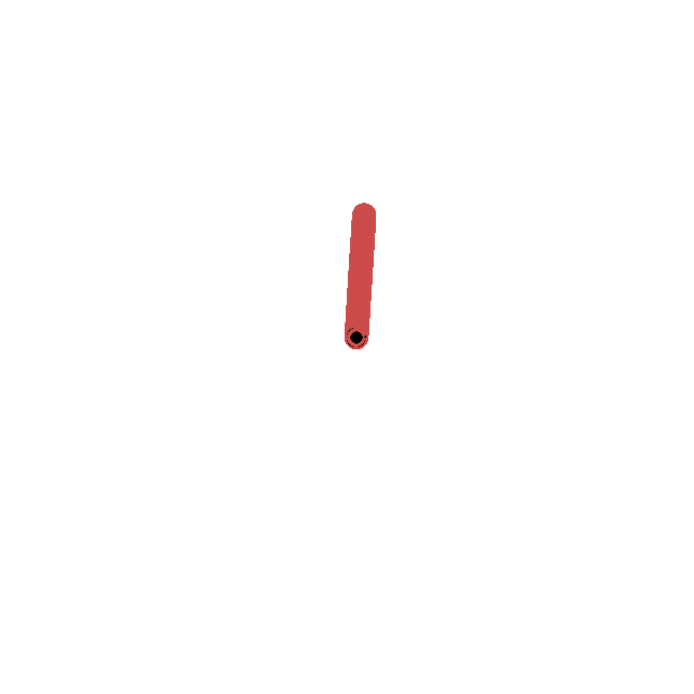
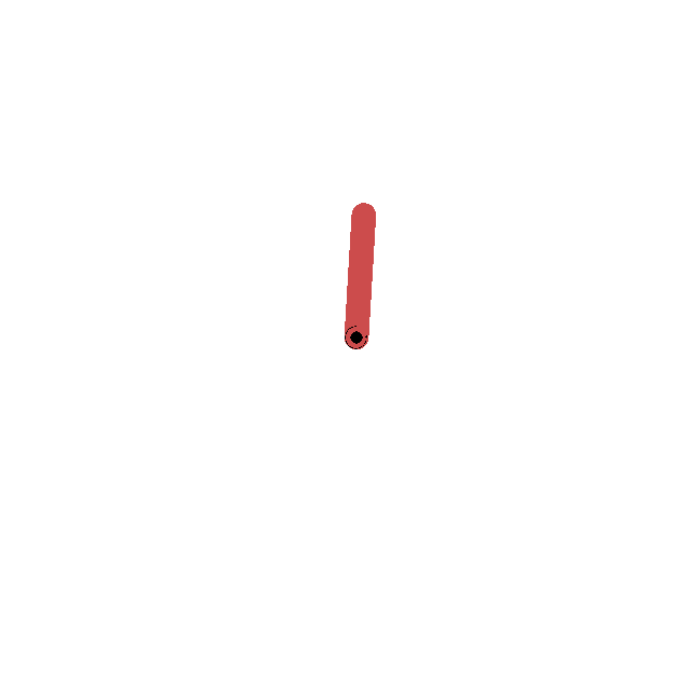
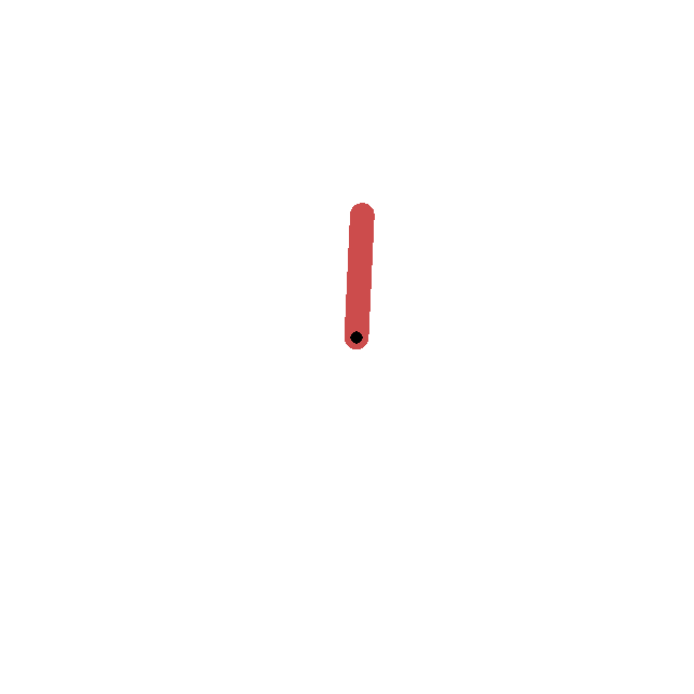
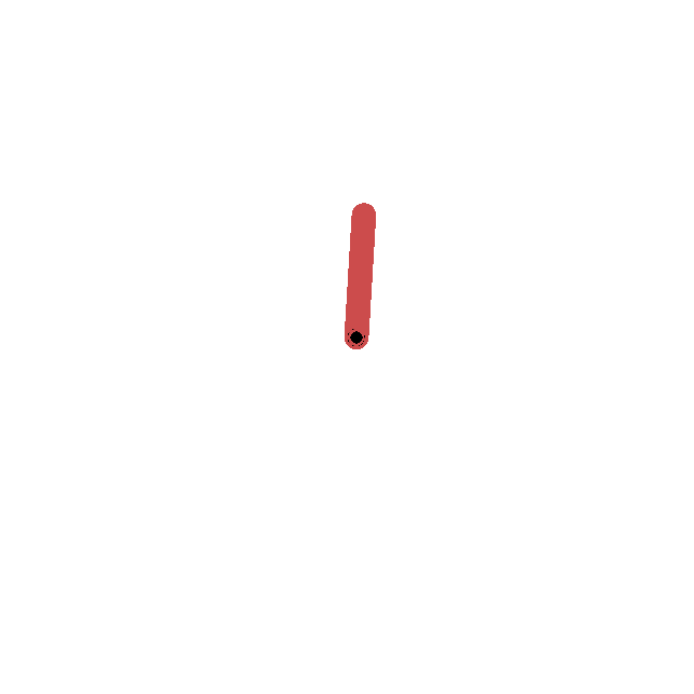
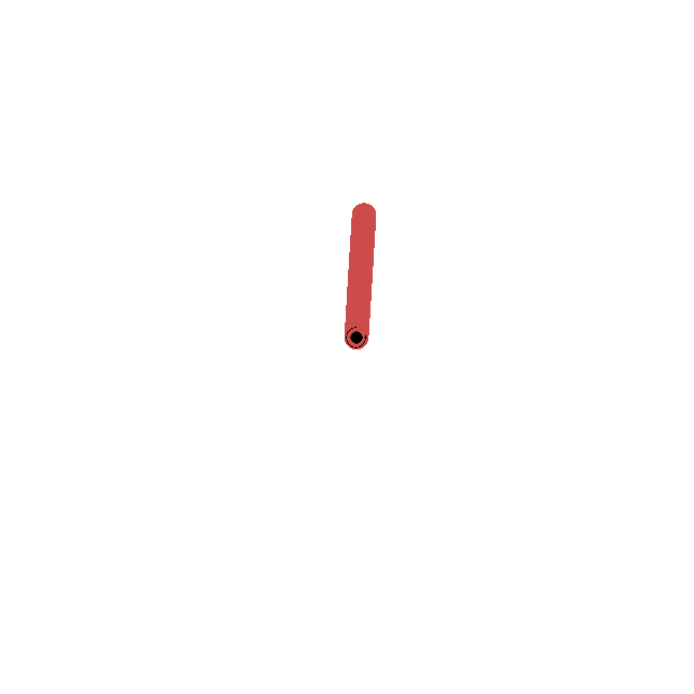
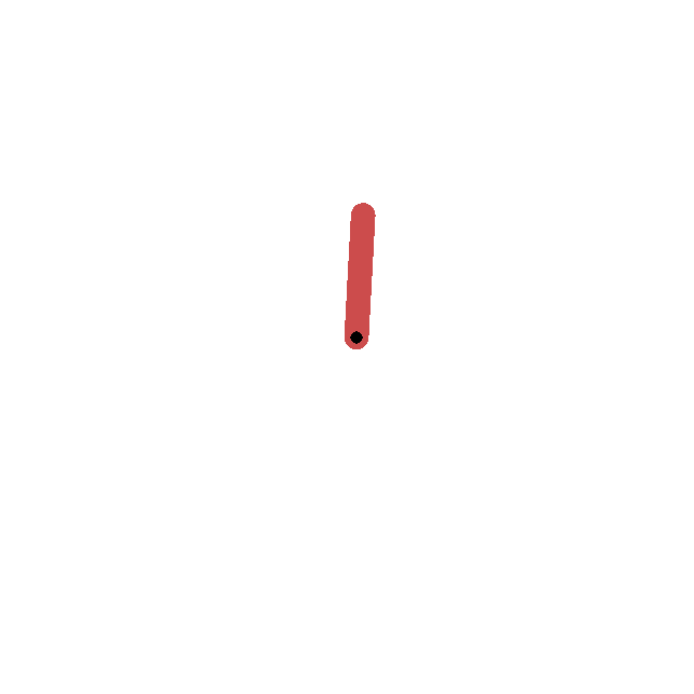
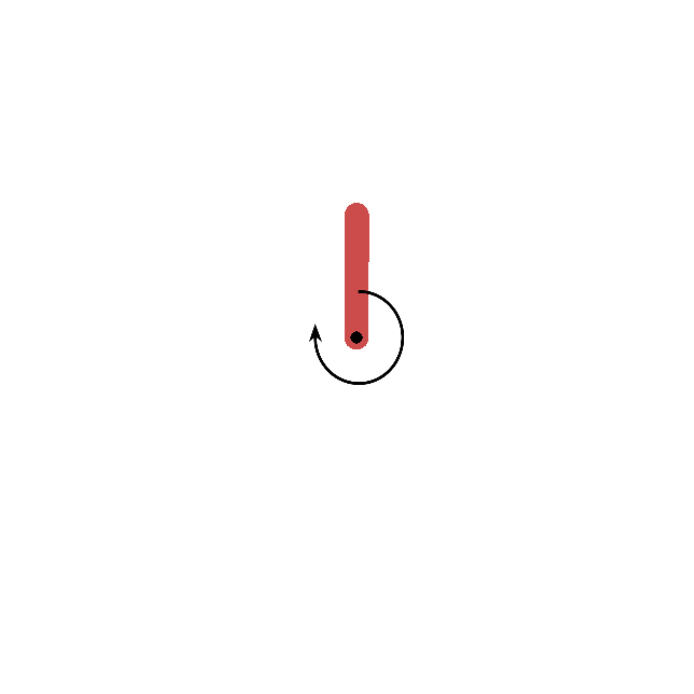
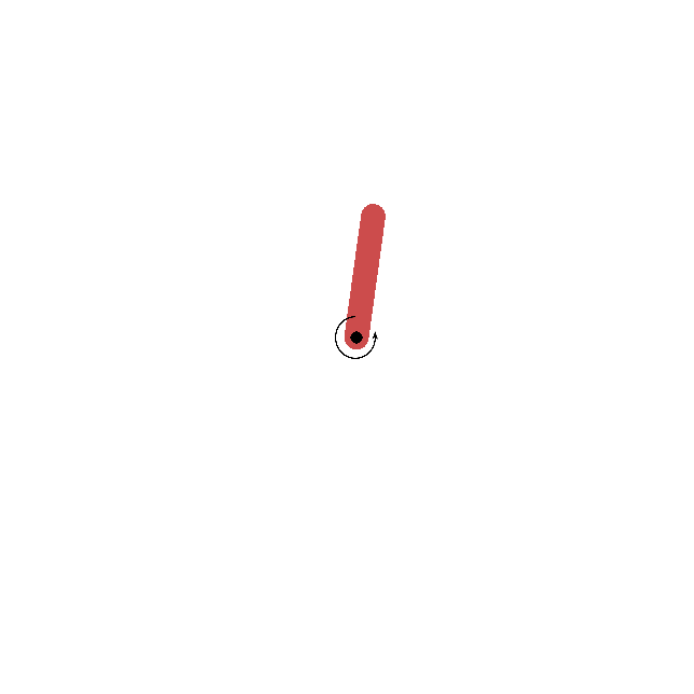
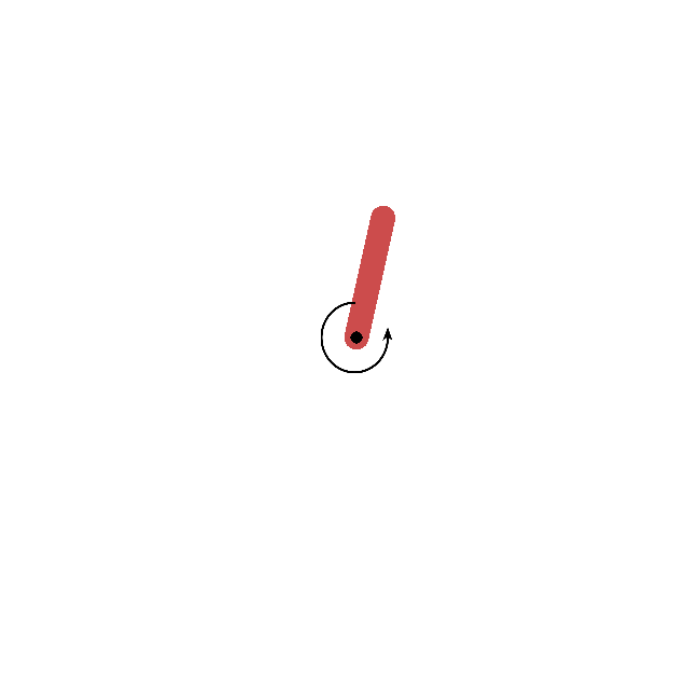
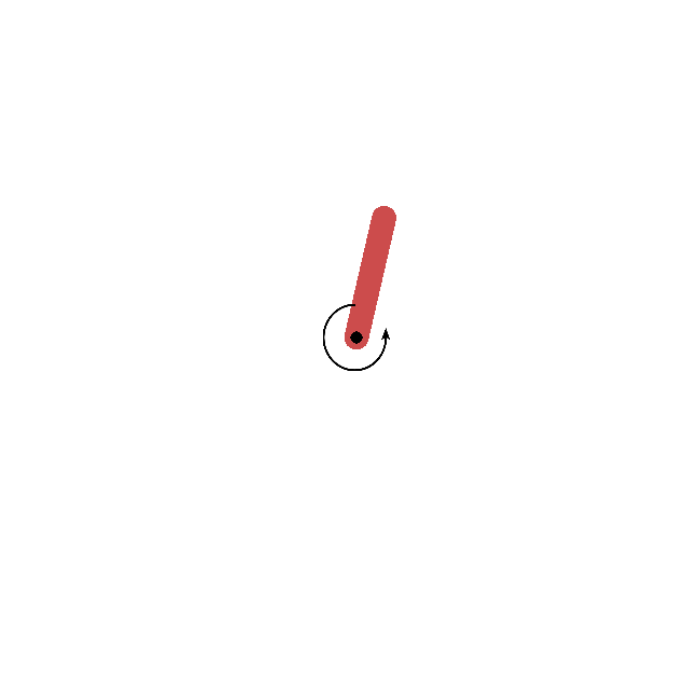
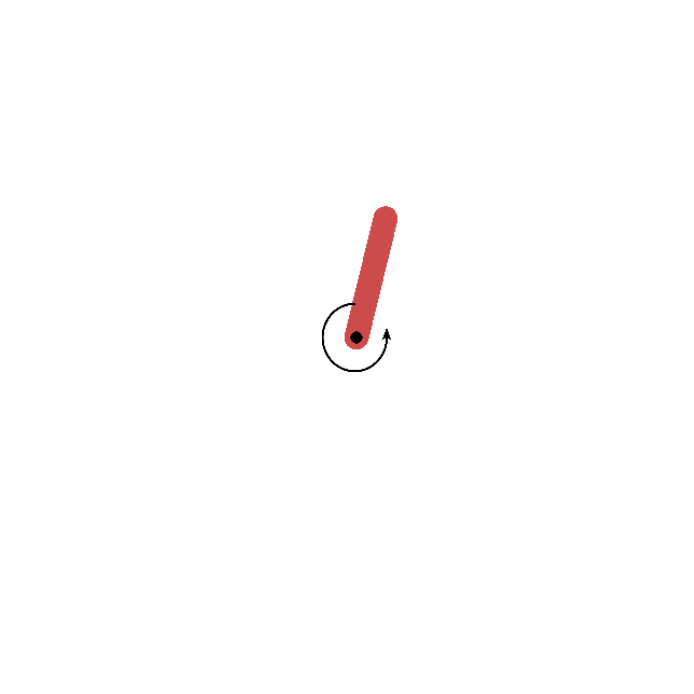
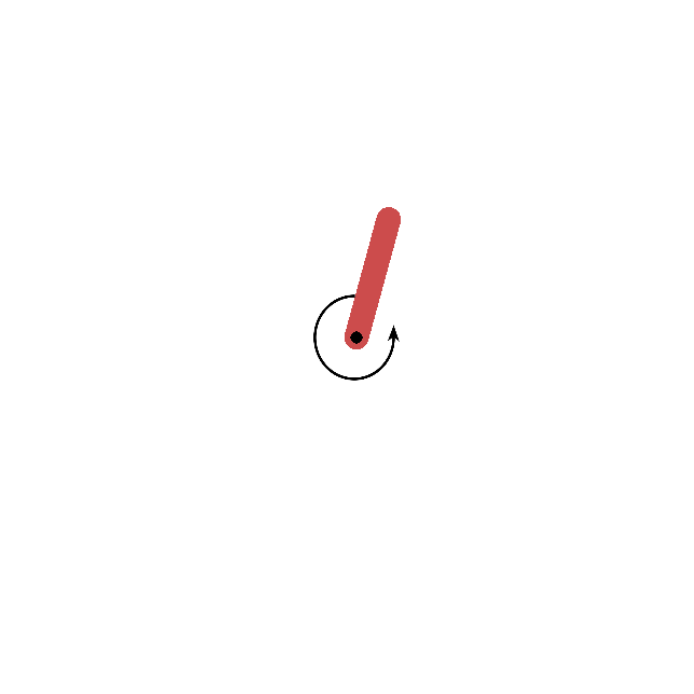
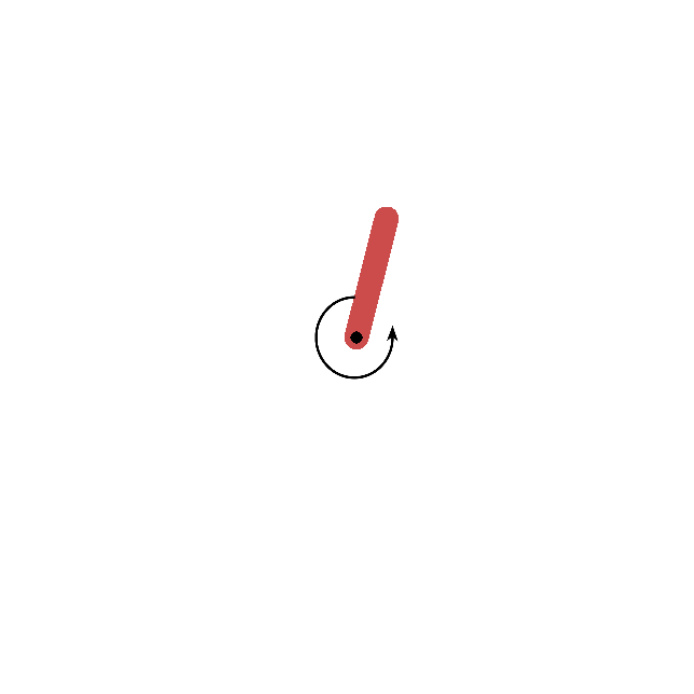
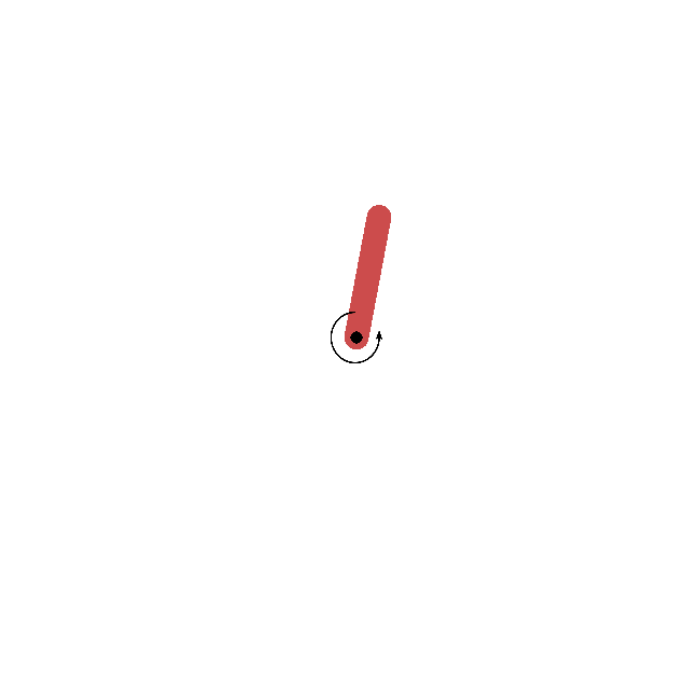
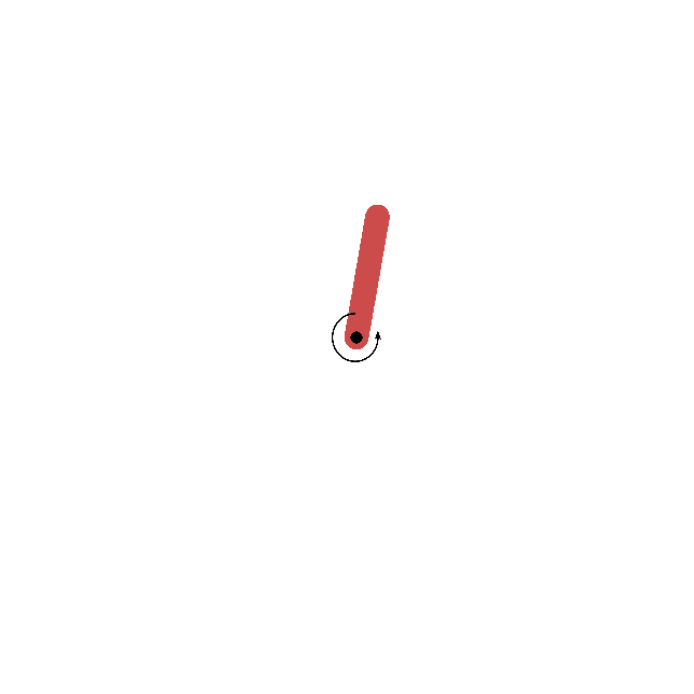
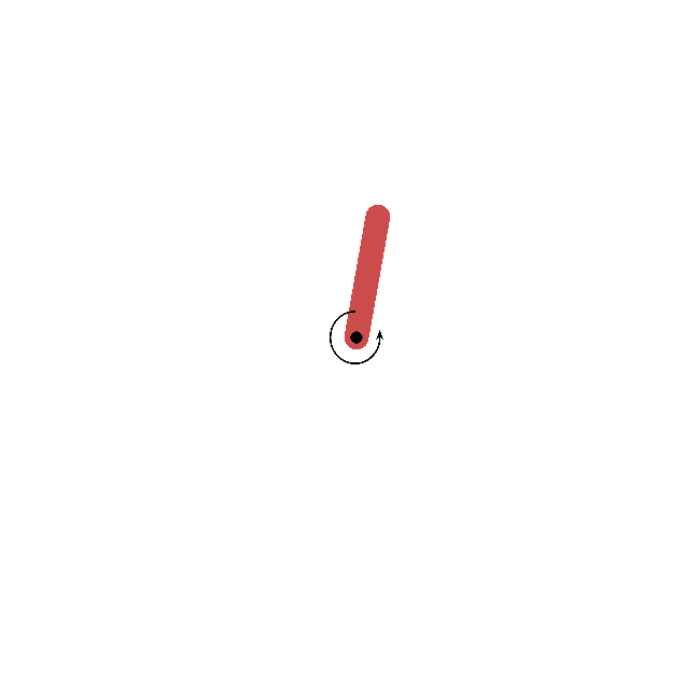
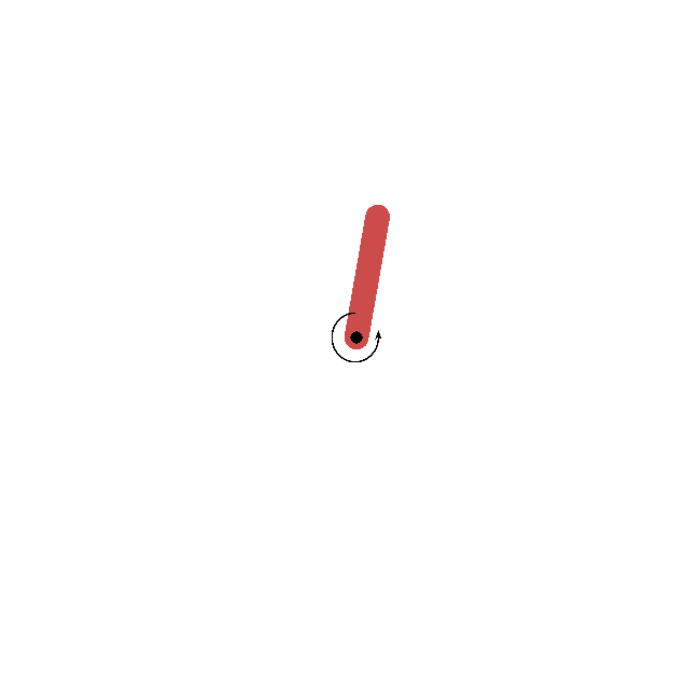
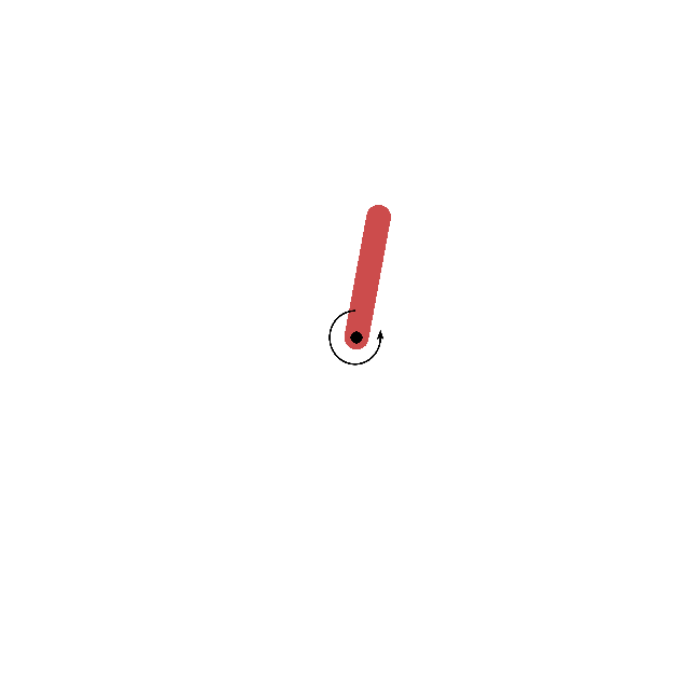
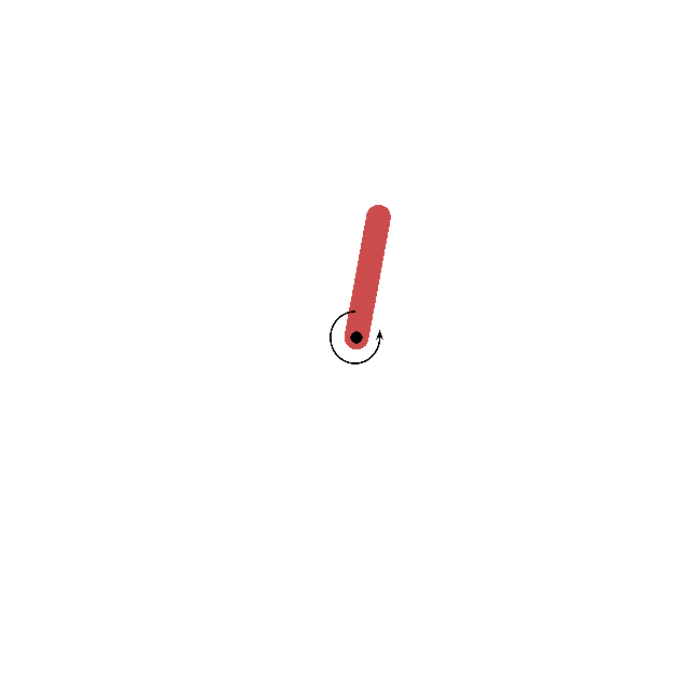
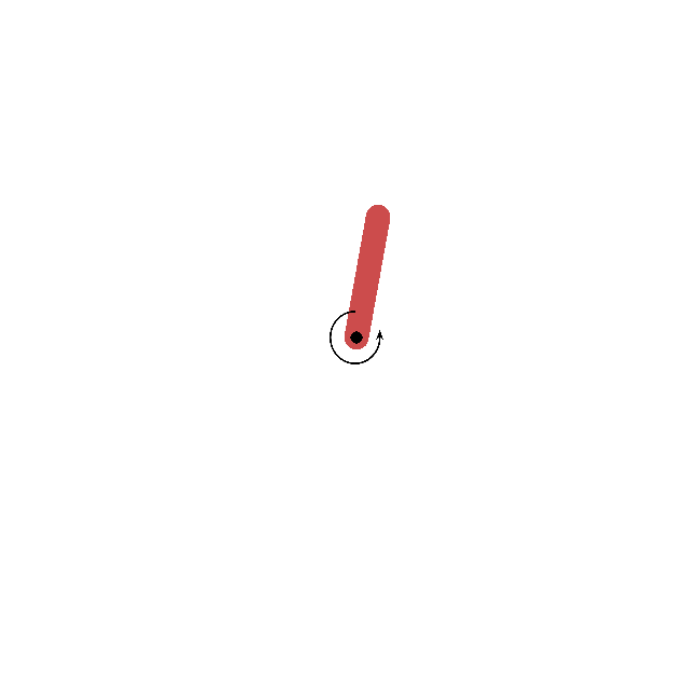
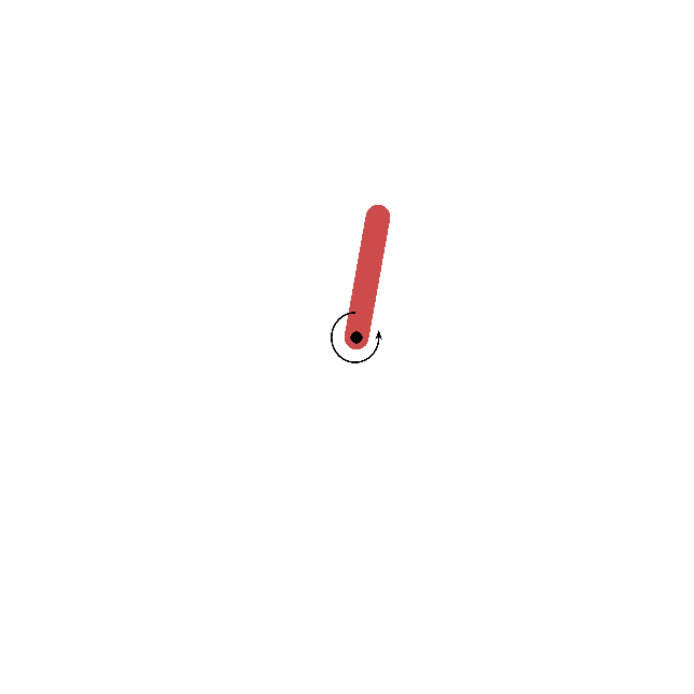
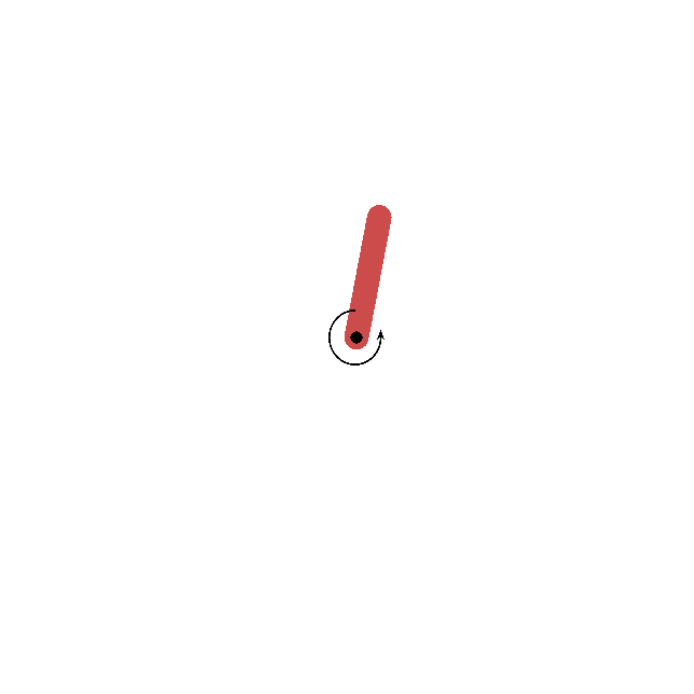
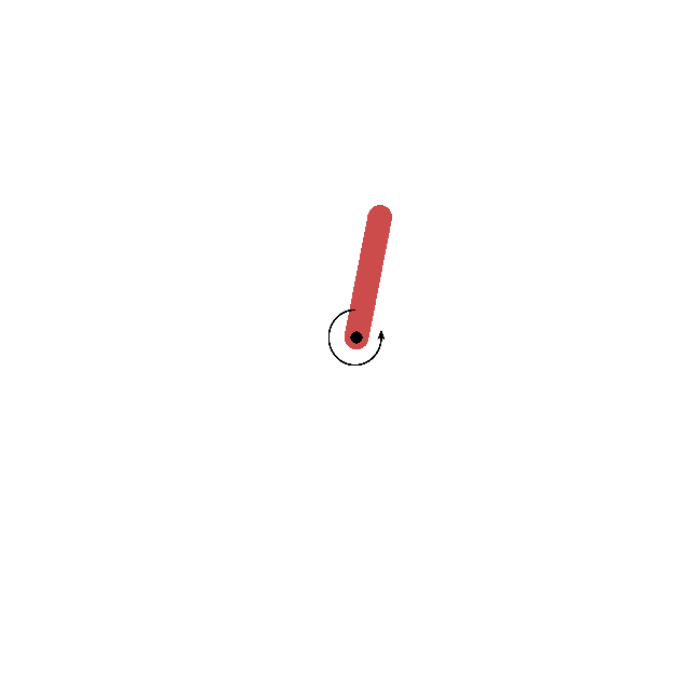
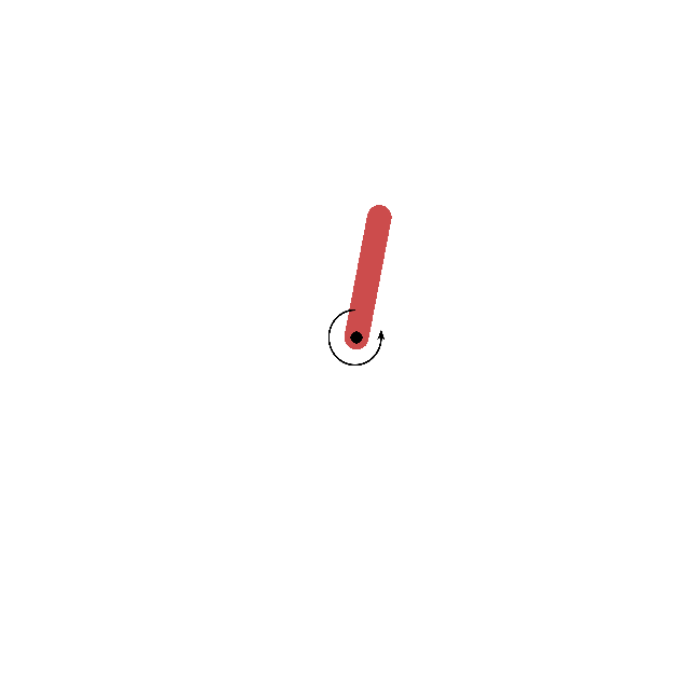
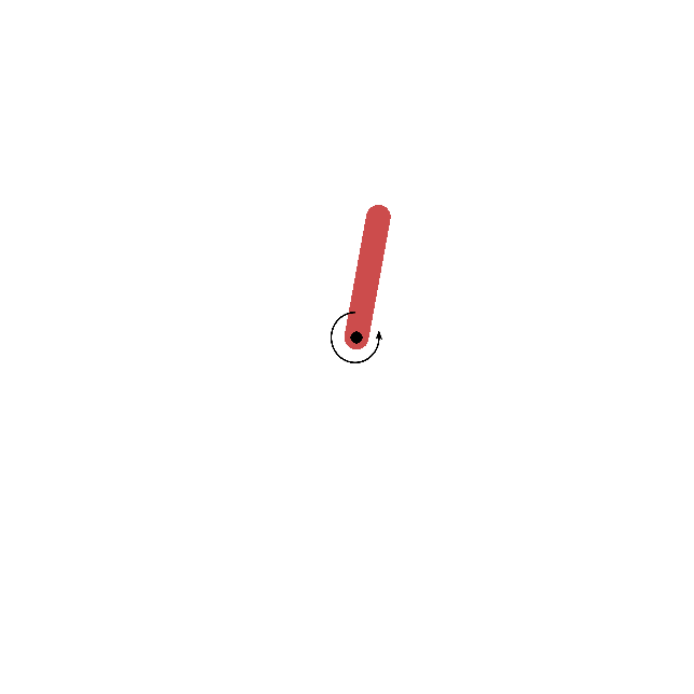
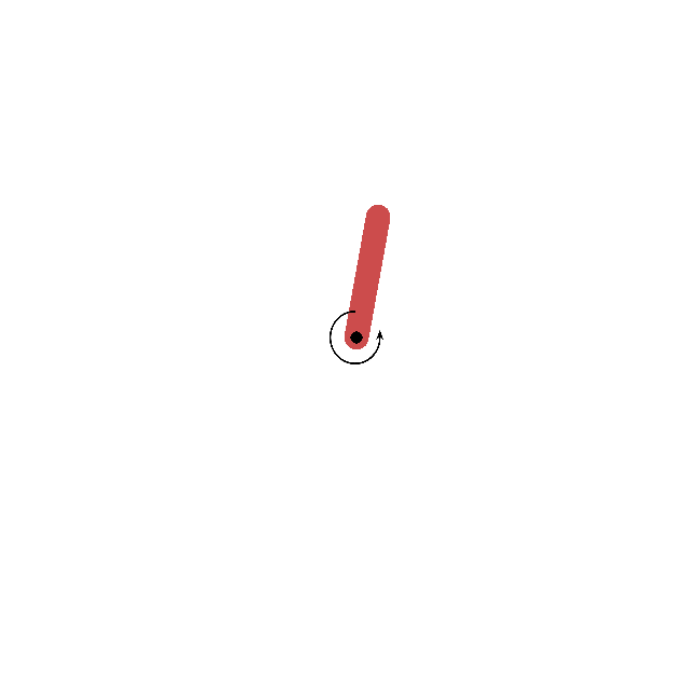
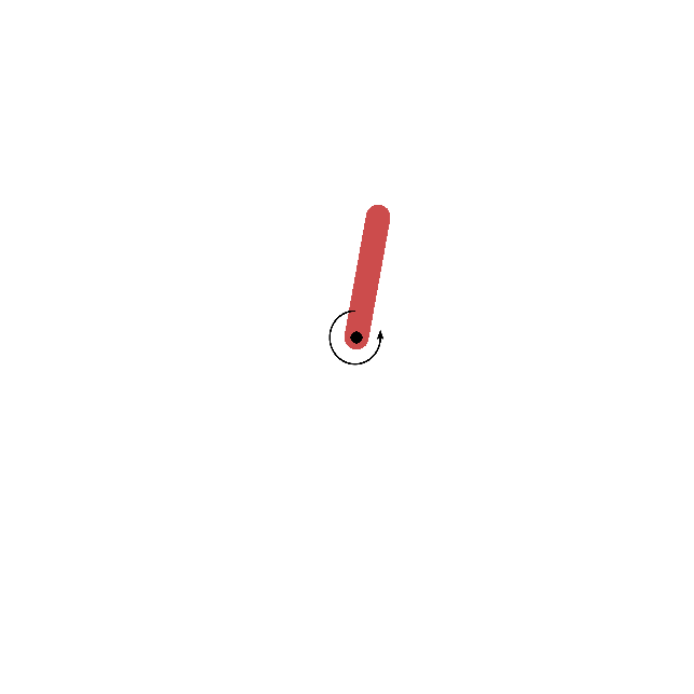
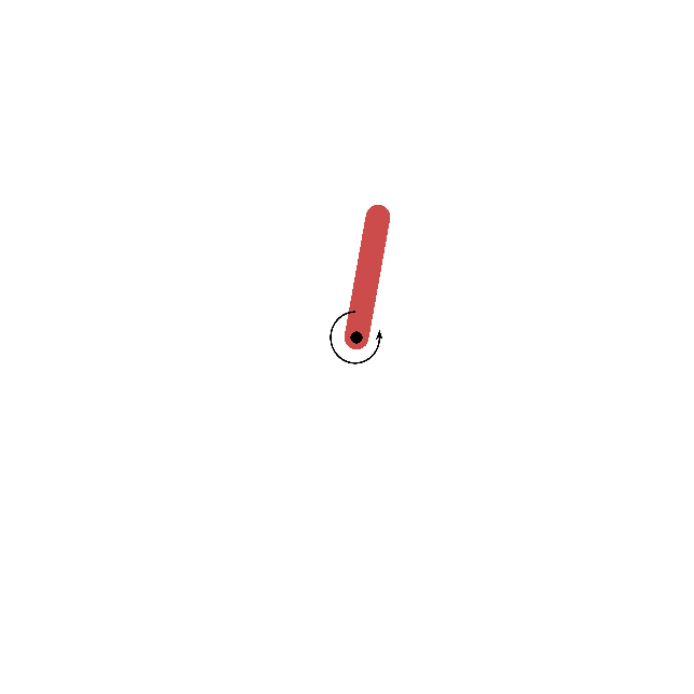
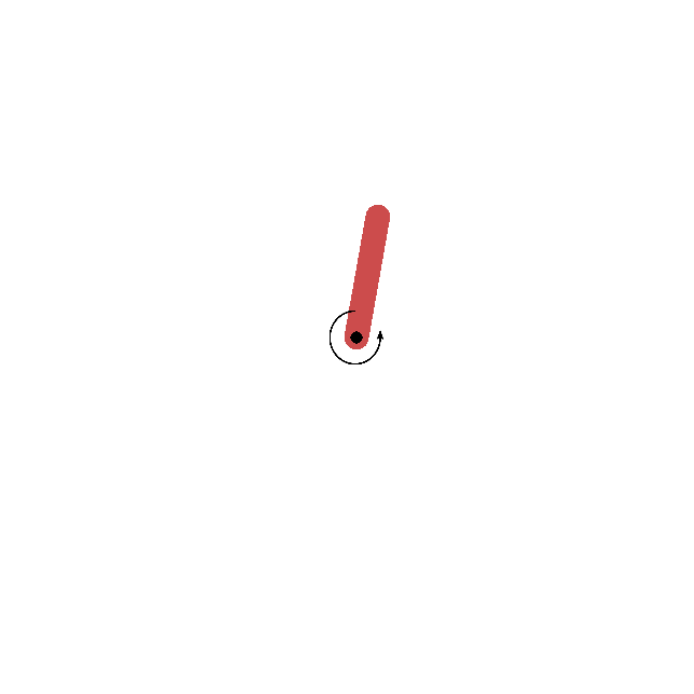
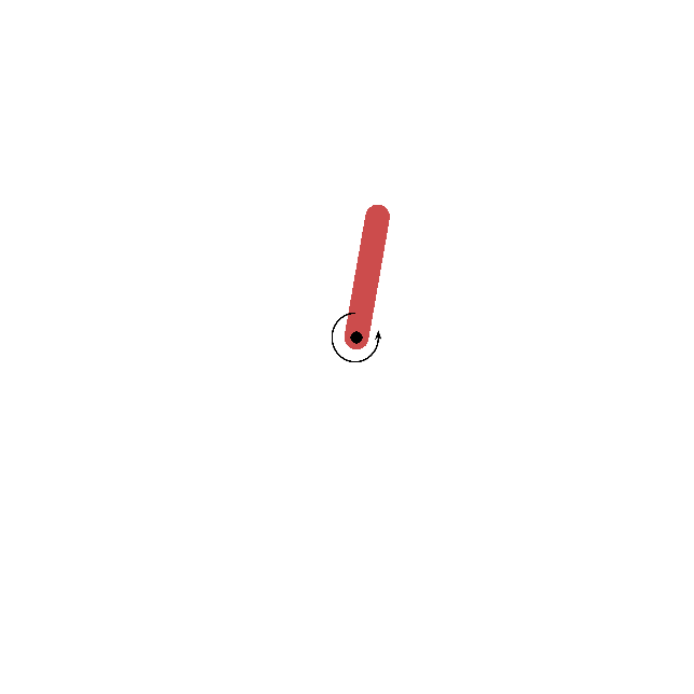
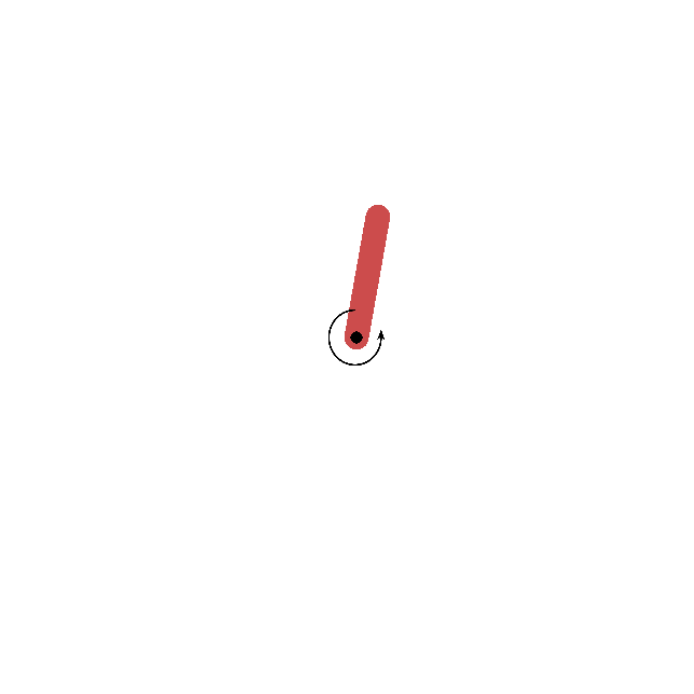
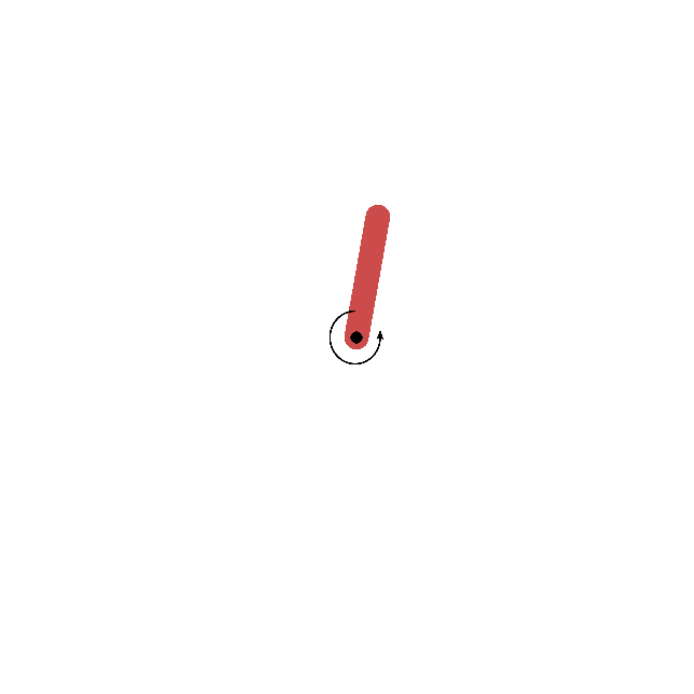
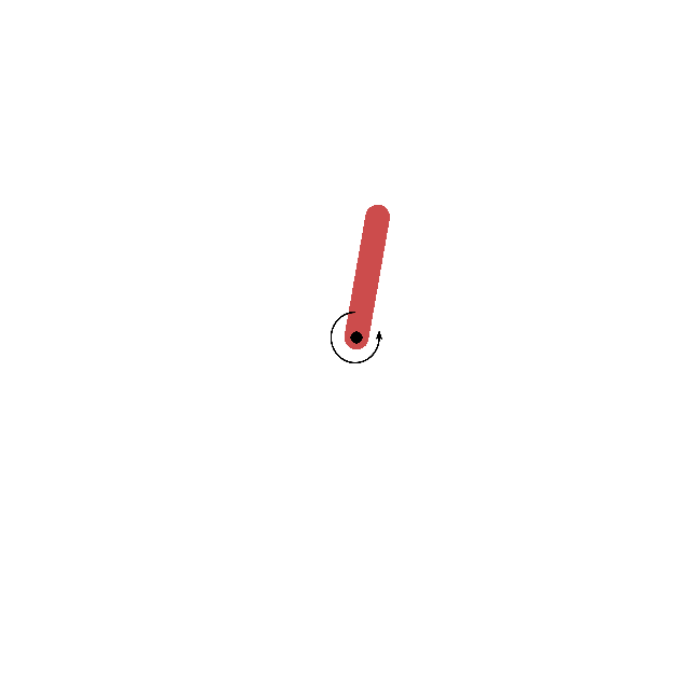

In [23]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [24]:
#session.close() 

In [25]:
exp.print_all_tf_variables()

(u'Actor_hidden_0_256_W:0', array([[  6.63227290e-02,   5.95367193e-01,  -1.66249350e-02,
         -1.09033275e+00,  -1.61581174e-01,  -1.13647020e+00,
          6.61843598e-01,  -1.10280603e-01,  -8.11574161e-01,
          2.96660215e-01,  -4.37577873e-01,   6.78467870e-01,
          1.32957175e-01,  -8.96557346e-02,  -8.89970243e-01,
          6.33901834e-01,   6.32686555e-01,   3.42035666e-02,
         -2.20910758e-01,   5.44367194e-01,   4.74748343e-01,
          3.87537807e-01,  -2.91874260e-01,  -8.72541249e-01,
         -1.30281401e+00,   2.21873149e-01,   7.10473835e-01,
         -2.73616135e-01,   8.81317973e-01,  -1.38727319e+00,
          3.01337510e-01,  -1.27615047e+00,   3.80553335e-01,
          5.78827262e-01,   9.42589521e-01,  -1.63761556e-01,
          8.10429394e-01,  -8.45926166e-01,  -1.89710036e-02,
         -1.52005768e+00,  -1.39658594e+00,   3.26709569e-01,
          3.64457704e-02,   1.32256317e+00,   6.92487657e-01,
          3.01047355e-01,  -9.34628129e-01